# Grandes étapes de l'algorithme (version Fortran77)


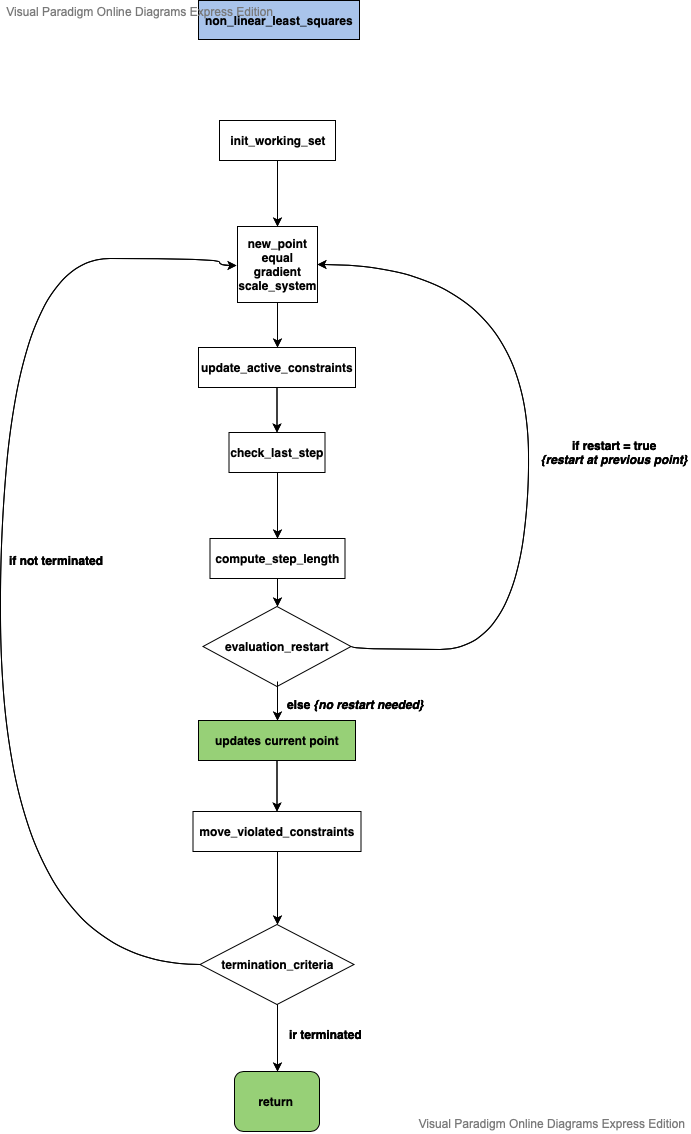


 

In [1]:
using LinearAlgebra
using Plots
using Polynomials
using Random
using ForwardDiff

# Squelette du main 


In [2]:
# Fonctions appelées dans nlcls_skeleton

function init_work_space(model::Function , x::AbstractArray{Float64}, constraints::Function)
end

function check_termination_criteria(f::Function, x::AbstractArray{Float64})
    return true
end

function new_point(x::AbstractArray{Float64}, f::Function, h::Function)
end

function update_acitve_constraints(model::Function, constraints::Function, x::AbstractArray{Float64},
    latest_step::String)
end

function check_last_step(dx::AbstractArray{Float64}, f::Function, h::Function, lastest_step::String)
end

function compute_steplength(f::Function, x::AbstractArray{Float64}, dx::AbstractArray{Float64}
        , h::Function, psi::Function)
end

function evaluation_restart(f::Function, dx, alpha::Float64, h::Function, latest_step::String)
end

function move_violated_constraints(f::Function, x::AbstractArray{Float64}, h::Function)
end

move_violated_constraints (generic function with 1 method)

In [3]:
# Ne comporte pas (encore) de gestion d'erreurs
# Paramètres à détailler au fur et à lesure de l'avancement

function nlcls_skeleton(model::Function, initial_point::AbstractArray{Float64}, merit_function::Function, 
        constraints::Function)
    # Tests sur les paramètres de départ à rajouter
    
    # Initialisation des paramètres et de l'espace de travail
    
    x, dx, iter = initial_point, zeros(size(initial_point)), 0
    init_workspace(model, x, constraints)
    terminated = check_termination_criteria(model, x)
    while !terminated
        # Mise à jour de l'espace de travail avec le nouveau point
        new_point(x, model, constraints)
        latest_step = "GN"
        
        # Mise à jour des contraintes actives et calcul de la direction Gauss-Newton
        dx = update_active_constraints(model, constraints, x, latest_step)
        
        # Vérification de la dernière étape et recalcul de la direction avec méthode TQR ou Newton si besoin est
        check_last_step(dx, model, constraints, lastest_step)
        
        # Calcul du pas de l'itération (vaut 1 si méthode de Newton utilisée)
        alpha = (latest_step == "Newton" ? 1 : compute_steplength(model, x, dx, constraints, merit_function))
        
        # Si pas de restart : mise à jour du point et des contraintes
        if !evaluation_restart(model, dx, alpha, constraints, latest_step)
            x += alpha * dx
            k += 1
            move_violated_constraints(model, x, constraints)
            terminated = check_termination_criteria(model, x)
        end
    end
    return x, k
end

nlcls_skeleton (generic function with 1 method)

In [4]:
# Reprend la structure du code de l'article

function nlcls_article_skeleton(objective_function, constraints, initial_point, merit_function )
    # vérification qu'il n'y pas d'erreurs dans les paramètres, pb de dimension par ex.
    # à détailler
    
    # initialisation des paramètres
    latest_step, first, phase = "GN", "GN", "normal"
    
    # not sure about p = 0 as an initial value
    k, x, p = 0, initial_point, 0

    
    # initialisation du premier workspace
    init_work_space(objective_function, contraintes);
    terminated = check_termination_criteria(objective_function, x)
    while !terminated
        # updates the system to solve with the new point
        new_point(), equal(), gradient(), scale_system()
        if phase != "Newton"
            while !terminated || !accept_direction(p_k) || phase != "Newton"
                
                # determination of working set and computation of direction are in update_active_constraints
                # computation of GN or subspace minimization search direction
                p_k = update_active_constraints()
                if !terminated
                    compute_penalty_weights(merit_function, x)
                    alpha = compute_step_length(merit_function, x, p)
                    
                    if !accept_direction(p)
                        if phase != "recovery" phase = "sighting" end
                    else
                        x = x + alpha * p
                        k += 1
                        if phase != "recovery" phase = "normal" end
                    end
                    # in this case, check_last_step only analyses the last step
                    # moreover, it doesn't compute SUB nor Newton direction
                    phase = check_last_step(latest_step, phase, first, alpha)
                end
            end
        # use an undamped Newton type method
        else
            count = 0
            newton_failure = false
            while !terminated || !newton_failure
                pn, newton_failure = newton_search_direction(objective_function, x)
                if !terminated
                    x = x + p
                    k += 1
                end
            end
            if newton_failure
                phase, first = "recovery", "GN"
            end
        end
    end
    return x
end
    

nlcls_article_skeleton (generic function with 1 method)

# Direction Gauss-Newton

On considère le problème d'optimisation $\underset{x \in \mathbb{R}^n }{min} \dfrac{1}{2} ||f(x)||^2 \\ s.c \ c(x) = 0$



### Construction d'un type $step$ dont les attributs contiennent toutes les informations de l'étape en cours

<b> Attributs </b>
- $first$ : booléen qui définit si l'étape en cours est la première effectuée l'algorithme ou non.
- $phase$ : Caractérise la méthode utilisée pour calculer la direction de descente ($GN$, $TQR$ ou $Newton$).
- $x$ : Vecteur implémenté dans l'étape.
- $dx$ : Direction de descente implémentée dans l'étape.
- $\alpha$ = Valeur du pas calculée.
- $\beta$ = Norme du projeté orthogonal du vecteur de la fonction objectif au point courant sur l'espace des colonnes de la matrice jacobienne de cette même fonction ($\beta_k = ||P_{J_k}f(x_k)||)$.
- $t$ et $s$ : Dimensions des sous-espaces utilisés  pour calculer les composantes de la direction de recherche avec la méthode $TQR$ ($\omega = t+s$ est alors la dimension complète du sous-espace).

In [2]:
mutable struct Step
    first::Bool
    phase::String
    x::Vector
    dx::Vector
    α::Float64
    β::Float64
    t::Int64
    s::Int64
    
    function Step(phase::String, point::Vector, first::Bool = false)
        new(first, phase, point, zeros(length(point)), 0.0, 0.0, 0, 0)
    end
   
end

function show(step::Step)
    println("phase = $(step.phase)")
    println("x = $(step.x)")
    println("dx = $(step.dx)")
    println("α = $(step.α)")
end

show (generic function with 1 method)

### Gauss-Newton sans contraintes

Trouve la direction $p$ qui satisfait $\underset{p \in \mathbb{R}^n }{min} \dfrac{1}{2} ||Jp + f(x)||^2$

où $J$ est la jacobienne de $f$ et $x$ le point courant.

In [3]:
# solve min [0.5*||Ax - b||^2] using QR decomposition and without constraints
#        x
# Also can return the matrix Q from the QR decomposition in order to compute the convergence factor (à changer)

function gn_direction_unconstrained(A::Matrix, b::Array)
    m,n = size(A)
    εrank = sqrt(eps(Float64))
    # QR decomposition of matrix A
    decomp_A = qr(A, Val(true))
    P, Q, R = decomp_A.P, decomp_A.Q, decomp_A.R
    d = (transpose(Q) * b)[1:n]

    # Index that avoids computation problems with A

    
    t_acc = rank(R) #maximum([j for j=1:n if abs(R[j,j]) >= εrank])
    
    # Computation of the GN search direction dx 
    dx = [UpperTriangular(R[1:t_acc, 1:t_acc]) \ d[1:t_acc];zeros(n-t_acc)]

    return P * dx
        
end

gn_direction_unconstrained (generic function with 1 method)

### Gauss-Newton avec contraintes d'égalité


Trouve la direction $p$ qui satisfait $\underset{p \in \mathbb{R}^n }{min} \dfrac{1}{2} ||Jp + f(x)||^2 \\ s.c \ Ap + c(x) = 0$

où $J$ est la jacobienne de $f$, $A$ celle de $c$ la fonction des contraintes et $x$ le point courant.

In [4]:
function gn_equality_constrained(J::Matrix, A::Matrix, fx::Vector, cx::Vector, step::Step, last_step::Step)
    m, n = size(J)
    q = length(cx)
    εrank, σ = sqrt(eps(Float64)), 100
    
    # LQ decomposition of matrix A (ie QR decomposition of transpose(A))
    lq_decomp_A = qr(transpose(A), Val(true))
    P1, Q1, L11 = lq_decomp_A.P, lq_decomp_A.Q, transpose(lq_decomp_A.R)

    t_bar = maximum([j for j=1:q if abs(L11[j,j]) >  εrank])
    
    # If stabilization is needed
    if t_bar < q
        step.phase = "TQR"

        # QR decomposition of L11
        qr_decomp_L11 = qr(L11, Val(true))
        P2, Q2, R11 = qr_decomp_L11.P, qr_decomp_L11.Q, qr_decomp_L11.R

        # Determination of first component of the solution 
        b = -transpose(P1 * Q2) * cx
        t = unconstrained_truncation_rule(R11, P2, b, last_step.t, last_step.phase)
        step.t = t
        δp1 = UpperTriangular(R11[1:t, 1:t]) \ b[1:t]
        p1 = P2 * [δp1; zeros(q-t)]

        # Determination of second component of the solution 
        JQ1 = J * Q1
        J1, J2 = JQ1[:,1:q], JQ1[:,q+1:n]
        R1 = J1 * P2

        # Solve  min [0.5*||J2 * p2 +f(x) + R11*p1||^2] 
        #         p2
        qr_decomp_J2 = qr(J2, Val(true))
        P3, Q3, R22 = qr_decomp_J2.P, qr_decomp_J2.Q, qr_decomp_J2.R
        d = -transpose(Q3)* (fx + R1*p1)
        
        # Dimension used for this step
        s = unconstrained_truncation_rule(R22, P3, d, last_step.s, last_step.phase)
        step.s = s
        
        δp2 = UpperTriangular(R22[1:s, 1:s]) \ d[1:s]
        
        if norm(transpose(A) * cx) * norm(δp2) >= σ
            step.s = 0
            p2 = zeros(n - q)
        else
            p2 = [δp2; zeros(n - q - s)]
        end
        

            
    # No stabilization is needed and direction computed with null space method
    # ie : The transformation of L11 is not needed
    else

        # First part of the solution
        p1 = (P1 * L11) \ -cx

        
        JQ1 = J * Q1
        J1, J2 = JQ1[:,1:q], JQ1[:,q+1:n]
        p2 = gn_direction_unconstrained(J2, -(J1*p1 + fx))
        step.t, step.s = q, n-q
    end
    p = Q1 * [p1; p2]

    return Q1 * [p1; p2]
end

gn_equality_constrained (generic function with 1 method)

In [5]:
# cf article p.15
function subspace_dimension(t_acc::Int64, r::Int64, τ_list::Array, ω::Int64, latest_phase::String)
    γ = 10 * sqrt(eps(Float64))
    mindim = minimum([j for j=1:r if τ_list[j] >= γ * τ_list[r]])
    if latest_phase == "GN"
        dim = maximum(Dict(τ_list[j] / τ_list[j+1] => j for j=1:(t_acc - 1))).second
    elseif t_acc <= r
        dim = r
    else
        dim = maximum(Dict(τ_list[j] / τ_list[j+1] => j for j=r:(t_acc - 1))).second
    end
    # TO Add:
    # if last_step_good_enough
    #    dim = max(dim, ω+1)
    return max(dim, mindim)
end


function unconstrained_truncation_rule(R::Matrix, P::Matrix, d::Vector, ω::Int64, latest_phase::String)
    ε_rank = sqrt(eps(Float64))
    diagR = diag(R)
    n = length(diagR)
    t_acc = rank(R) #maximum([j for j=1:n if abs(diagR[j]) >= ε_rank])
    τ_list = [norm(d[1:i]) * abs(diagR[i]) for i=1:n]
    r = maximum(Dict(τ_list[i] => i for i=1:n)).second
    return (t_acc <= r ? r : subspace_dimension(t_acc, r, τ_list, ω, latest_phase)) 
end

unconstrained_truncation_rule (generic function with 1 method)

# Calcul du pas

 <b> TODO </b> : Implémentation du pas avec la méthode de l'algorithme originel

### Calcul du pas avec la méthode d'Armijo-Goldstein

In [6]:
# Choix des valeurs de c et τ à approfondir (vu c = 0.25 et τ = 0.5 dans le code)
# L'article conseille d'utiliser 3 comme borne supérieure du pas

function armijo_step(r::Function, grad_fx::Vector, x::Vector, dx::Vector,
        α_upper::Float64 = 3.0, c::Float64 = 0.1, τ::Float64 = 0.2)
    m = - c * dot(grad_fx, dx)
    α = α_upper
    f = x::Vector -> 0.5 * norm(r(x))^2
    fx, ψx = f(x), f(x + α * dx)
    
    while fx - ψx <= α * m
        α *= τ
        fx, ψx = f(x), f(x + α * dx)
    end
    return α
end

armijo_step (generic function with 4 methods)

### Calcul du pas avec la méthode de Lindstörm-Wedin utilisée dans le code Fortran

Ici, on a $f :
    \begin{array}{l l}
      \mathbb{R} \rightarrow \mathbb{R}^m & \\
      \alpha \rightarrow r(x + \alpha * dx)
   \end{array}
   $
où $r$ est la fonction objectif du problème que l'on cherche à minimiser, $x$ et $dx$ fixés (?) sont respectivement le point courant et la direction de descente calculée à l'aide de la méthode de Gauss-Newton.


<b> Idée </b> : Minimiser $\phi(\alpha) = \dfrac{1}{2} ||r(x + \alpha dx)||^2 = \dfrac{1}{2} ||f(\alpha)||^2$ ,où $r$ est la fonction objectif du problème, par minimisation d'une approximation polynomiale $p$ de $f$.

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

<b> Fonctions préliminaires </b>

- <b> minrm </b> : Calcule le minimum de la fonction polynomiale $s(\alpha) = \dfrac{1}{2} ||p(\alpha)||^2$ avec $p(\alpha) = v_0 + v_1\alpha + v_2\alpha^2$, $v_k \in \mathbb{R}^m$ pour $k \in \{1, 2, 3\}$.
- <b> parameters_rm </b> : Calcule $\hat{\alpha}$ et $\hat{\beta}$ les deux minimiseurs de $s$ ($\alpha$ étant le minimiseur le plus pertinent).

- <b> bounds! </b> : Réajuste $\hat{\alpha}$ dans le cas où il ne se situe pas dans l'intervalle $[\alpha_l,\alpha_u]$ en remplaçant sa valeur par celle de la borne la plus proche.

- <b> newton_raphson </b> : Résout $s'(\alpha) = 0$ par la méthode de Newton-Raphson dans le cas où le critère de convergence de la résolution analytique $s''(\alpha_{best}) * \eta < 2*D_m*h_m$ n'est pas respecté.

- <b> one_root, two_roots </b> : Renvoient la/les racines réelles de $s'(\alpha) = 0$ si le critère ci-dessus pour la résolution analytique est respecté. Pour <b>two_roots</b>, $\alpha$ est la meilleure des deux racines pour le problème. 

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

In [7]:
function parameters_rm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64,
        ds::Polynomial{Float64}, dds::Polynomial{Float64})
    dds_best = dds(α_best)
    η, d = 0.1, 1.
    h0 = abs(ds(α_best) / dds_best )
    Dm = abs(6*dot(v1,v2) + 12*α_best*norm(v2)^2) + 24*h0*norm(v2)^2
    hm = max(h0, 1)

    # s'(α) = 0 is solved analytically
    if dds_best * η < 2 * Dm * hm
        
        # If t = α+a1 solves t^3 + b*t + c = O then α solves s'(α) = 0
        (a3, a2, a1) = coeffs(ds) / (2 * norm(v2)^2)
        
        b = a2 - (a1^2) / 3
        c = a3 - a1 * a2/3 + 2*(a1/3)^3
        d = (c/2)^2 + (b/3)^3
        # Two interisting roots
        if d < 0
            α_hat, β_hat = two_roots(b, c, d, a1, α_best)
        
        # Only one root is computed     
        else
            α_hat = one_root(c, d, a1)
        end
    
    # s'(α) = 0 is solved using Newton-Raphson's method
    else
        α_hat = newton_raphson(α_best::Float64, Dm::Float64, ds, dds)
    end
    
    # If only one root computed
    if d >= 0 
        β_hat = α_hat 
    end
    return α_hat, β_hat
end

function bounds(α_l::Float64, α_u::Float64, α::Float64, s::Polynomial{Float64})
    α = min(α, α_u)
    α = max(α, α_l)
    return α, s(α)
end

function newton_raphson(α_best::Float64, Dm::Float64, ds::Polynomial{Float64}, dds::Polynomial{Float64})
    α, newtonstep = α_best, 0
    ε, error = 1e-4, 1.
    while error > ε || newtonstep < 3
        c = dds(α)
        h = -ds(α) / c
        α += h
        error = (2 * Dm * h^2) / abs(c)
        newtonstep += 1
    end
    return α
end

function one_root(c::Float64, d::Float64, a::Float64)
    arg1, arg2 = -c/2 + sqrt(d), -c/2 - sqrt(d)
    return cbrt(arg1) + cbrt(arg2) - a/3
end

function two_roots(b::Float64, c::Float64, d::Float64, a::Float64, α_best::Float64)
    φ = acos(abs(c/2) / (-b/3)^(3/2))
    t = (c <= 0 ? 2*sqrt(-b/3) : -2*sqrt(-b/3))
    
    # β1 is the global minimizerof s(α). 
    # If d is close to zero the root β1 is stable while β2 and β3 become unstable
    β1 = t * cos(φ/3) - a/3
    β2 = t * cos((φ + 2 * π) / 3) - a/3
    β3 = t * cos((φ + 4 * π) / 3) - a/3
    
    # Sort β1, β2 and β3 so that β1 <= β2 <= β3
    β1, β2, β3 = sort([β1, β2, β3])
    
    #β1 or β3 are now the roots of interest
    α, β = (α_best <= β2 ? (β1, β3) : (β3, β1))
    return α, β
end  

function minrm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64, α_l::Float64 = 1e-3, α_u::Float64 = 3.)
    
    s = Polynomial([0.5*norm(v0)^2, dot(v0,v1), dot(v0,v2) + 0.5*norm(v1)^2, dot(v1,v2), 0.5*norm(v2)^2])
    ds = derivative(s)
    dds = derivative(ds)
    α_hat, β_hat = parameters_rm(v0, v1, v2, α_best, ds, dds)
    sα, sβ = s(α_hat), s(β_hat)
    α_old = α_hat
    α_hat, sα = bounds(α_l, α_u, α_hat, s)
    if α_old == β_hat
        β_hat, sβ = α_hat, s(α_hat)
    else
        β_hat, sβ = bounds(α_l, α_u, β_hat, s)
    end
    return α_hat, sα, β_hat, sβ
end



minrm (generic function with 3 methods)

<b> Fonction d'interpolation polynomiale </b>

(à voir si on peut utiliser une fonction d'interpolation du module Polynomials) 

- <b> coeffs_interpolation_3p </b> Calcule et renvoie les coefficients de l'interpolation polynomiale de degré 2 de la fonction objectif vectorielle $f$ passant par les trois points $x_0, x_1, x_2$ suivante  :<p> $ p(\alpha) = f(x_0) + (\alpha - x_0)f[x_0, x_1] + (\alpha - x_0)(\alpha - x_1)f[x_0, x_1, x_2]$ </p> où les coefficients sont calculés à l'aide des différences divisées : $[x_j, x_k] = \dfrac{f(x_k)-f(x_j)}{x_k - x_j}$ et $f[x_i, x_j, x_k] = \dfrac{f[x_j, x_k]-f[x_j, x_i]}{x_k - x_i}$. Pour $(x_0, \ldots, x_n)$ et $y = (f(x_0), \ldots, f(x_n))$ en entrée, <b> divided_differences </b> renvoie le vecteur des différences divisées
 $(f[x_0], f[x_0, x_1], \ldots, f[x_0, \ldots, x_n])$
 
- <b> coeffs_interpolation_2p </b> Idem mais l'interpolation passe ici par deux points : $0$ et $\alpha_0$ donné. Ici, la formule de $p$ est directement donnée par : <p>$ p(\alpha) = f(0) + \alpha_0f[0,0] + \alpha^2f[0,0, \alpha_0]$</p> avec $f[0,0] = \nabla f(0)$ et $f[0,0, \alpha_0]$ donné par la formule des différences divisées ci-dessus.

In [8]:
function coeff_interpolation_3p(f::Function, x::Vector)
    function divided_differences(x::Vector, y::Vector)
        n, d = length(x), y
        for i=1:n
            for j=n:-1:i+1
                d[j] = (d[j] - d[j-1]) / (x[j] - x[j-i])
            end
        end
        return d
    end
    divdiff = divided_differences(x, map(f, x))
    v0 = divdiff[1] - x[1] * divdiff[2] + x[1] * x[2] * divdiff[3]
    v1 = divdiff[2] - (x[1] + x[2]) * divdiff[3]
    v2 = divdiff[3]
    return (v0, v1, v2)
end

function coeff_interpolation_2p(f::Function, gradf_0::Vector, α::Float64)
    v0 = f(0.)
    v1 = gradf_0
    v2 = (((f(α) - v0) / α) - gradf_0) / α
    return (v0, v1, v2)
end


coeff_interpolation_2p (generic function with 1 method)

<b> Algorithme de recherche du pas </b>

Calcule le pas avec plusieurs itérations de la méthode d'interpolation polynomiale décrite par la fonction <b>minrm</b> . Si le pas calculé n'est pas bon ou trop petit (critères à définir précisément), on calcule le pas d'Armijo-Goldstein.

In [9]:
function steplength_unconstrained(r::Function, jacobian_r::Function, x::Vector, dx::Vector, 
        α0::Float64, αl::Float64 = 0.016 * 3., αu::Float64 = 3.)
    # Definition of parameters and intermiediate functions
    f = α::Float64 -> r(x + α * dx)
    
    ∇f = α::Float64 -> jacobian_r(x + α * dx) * dx
        
    n = length(x)
    τ, γ = 0.25, 0.4
    ϕ = α::Float64 -> 0.5 * norm(f(α))^2
    jac_x = jacobian_r(x)
    ∇f0 = ∇f(0.)
    dϕ0 = dot(dx, transpose(jac_x) * jac_x * dx + transpose(jac_x) * r(x))
    
    is_acceptable = α::Float64 -> (ϕ(α) <= ϕ(0.) + τ * dϕ0 * α) || (ϕ(α) <= γ * ϕ(0.))
    
    function best_alpha(list_alpha::Vector, s::Function)
        minimum(Dict(s(t) => t for t in list_alpha)).second
    end
    
    function progress_check(s_star::Float64, ϕ::Function, αk::Float64, αk_1::Float64, η::Float64 = 0.2, δ::Float64 = 0.2)
        satisfied = true
        ϕk = ϕ(αk)
        if s_star <= η * ϕk
            if ϕk <= δ * ϕ(αk_1)
                satisfied = false
            end
        end
        return satisfied
    end
    
    k, α_1 = 0, 0.
    
    # Find minimum of parabola interpolating f at 0 and α0
    (v0, v1, v2) = coeff_interpolation_2p(f, ∇f0, α0)
    αbest = best_alpha([0, α0], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
    α_star, s_star = minrm(v0, v1, v2, αbest, αl, αu)
    
    if is_acceptable(α0)
        satisfied = progress_check(s_star, ϕ, α0, α_1)
        
        if !satisfied α1 = α_star end
        while !satisfied
            if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
            (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
            α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
            α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
            satisfied = progress_check(s_star, ϕ, α1, α0)
            if k == 0 k += 1 end
        end
        if k == 0 return α0 end
        
    else
        α1 = α_star
        if is_acceptable(α1)
            if ϕ(0.) <= ϕ(α0)
                (v0, v1, v2) = coeff_interpolation_2p(f, ∇f0, α1)
                α_best = best_alpha([0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                α0 = 0.
            else
                (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
                α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                satisfied = progress_check(s_star, ϕ, α1, α0)
                if !satisfied α1 = α_star end
                
                while !satisfied
                    if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
                    (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
                    α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                    α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                    satisfied = progress_check(s_star, ϕ, α1, α0)
                    if k == 0 k += 1 end
                end
            end
        else
            grad_fx = transpose(jacobian_r(x)) * r(x)
            α1 = armijo_step(r, grad_fx, x, dx, α1)
            
            # Rajouter "α1 est trop petit" et "α1 acceptable" comme condition d'arrêt
            
        end
            
        
    end
    return best_alpha([α0, α1], ϕ)
end

steplength_unconstrained (generic function with 3 methods)

### Vérification de l'étape précédente

<b> Idée </b> : Une fois la direction de Gauss-Newton calculée, on vérifie d'abord que l'on peut accepter cette direction (par la vérification sur le pas de $\alpha_k > \dfrac{\alpha_{upper}}{3000} $ dans le cas sans contraintes).

Ensuite, la direction GN est acceptée si une des conditons suivantes est vérifiée, sinon la direction de descente est calculée avec la méthode de Newton. :
1. L'étapte en cours est la première étape de l'algorithme
2. Le facteur de convergence $\dfrac{||P_{J_k}f(x_k)||}{||P_{J_{k-1}}f(x_{k-1})||} = \dfrac{\beta_k}{\beta_{k-1}}$ doit être ingérieur à $\delta$ compris entre $0$ et $1$ strictement ($\delta=0.5$ dans l'algorithme).
3. $||f(x_k)||^2 - ||f(x_{k+1}||^2 > c_1 \beta_k^2$ avec $0<c_1<1$ fixé. ($c_1 = 0.1$ dans l'algorithme).



In [10]:
function check_last_step(step::Step, x_old::Vector, α::Float64, dx::Vector, f::Function, 
        Jx::Matrix, last_step::Step, c1::Float64 = 0.1, δ::Float64 = 0.5)
    # Definition of parameters
    β_old = last_step.β
    n = length(x_old)
    x_new = x_old + α * dx
    Q = qr(Jx, Val(true)).Q
    β_new = norm((-transpose(Q) * f(x_new))[1:n])
    step.β = β_new
    convergence_factor = β_new / β_old
    reduction = norm(f(x_old))^2 - norm(f(x_new))^2
    
    # if one of those conditions is not respected un andamped Newton method is used
    if last_step.first || reduction >= c1 * β_new^2 || convergence_factor < δ
        step.phase = "GN"
    else
        step.phase = "Newton"
    
    end
end
        

check_last_step (generic function with 3 methods)

### Critère d'arrêt

Soit $Z$ la matrice de l'espace nul de la matrice jacobienne du problème à la $k$-ième étape $J_k$, $A_k$ la jacobienne des contraintes et $q$ le nombre de contraintes.

En considérant la linéarisation du problème initial et la méthode d'ajustement des poids de la fonction de mérite (à rajouter), l'algorithme converge vers un point où :

- si $rang(A_k)<q$ : $A^T_kc(x_k)=0$
- si $rang(A_k)=q$ : $c(x_k)=0$; $(J_kZ)^Tf(x_k)=0$ 

In [70]:
function check_termination_criteria(Jx::Matrix, Ax::Matrix, fx::Vector, cx::Vector, ε::Float64 = 1e-8)
    q = length(cx)
    if rank(Ax) < q
        println("Critère de terminaison :")
        println("A^Tc(x) = $(transpose(Ax) * cx) \n")
        return norm(transpose(Ax) * cx) < ε
    else
        m, n = size(Ax)
        
        
        # Computation of the null space matrix of Ax
        Q = qr(transpose(Ax)).Q
        Z = Q[:, m+1:n]
        println("Critères de terminaison :")
        println("||c(x)|| = $(norm(cx))")
        println("||(Jx * Z)^T * fx|| = $(norm(transpose(Jx * Z) * fx)) \n")
        
        return norm(cx) < ε && norm(transpose(Jx * Z) * fx) < ε
    end
end

check_termination_criteria (generic function with 2 methods)

In [213]:
A = [1. 2. 3.; 3. 6.2 7.8]
m, n = size(A)

decomp = qr(transpose(A))
L, Q = transpose(decomp.R), decomp.Q
Y = Q[:, 1:m]
Z = Q[:, m+1:n]
A*hcat(Y, Z)




2×3 Array{Float64,2}:
 4.44089e-16  4.44089e-16   6.66134e-16
 0.0          8.88178e-16  -4.996e-16

# Résolution d'un problème moindre carrés avec contraintes d'égalité


<b>Paramètres</b>:
- $ initial\_point$ : point de départ de la boucle principale
- $r$ : fonction vectorielle des résidus comportant les différences entre les sorties observées et les prédictions du modèle
- $J$ : matrice jacobienne de la fonction $r$
- $c$ : fonction vectorielle des contraintes (ici contraintes d'égalité)
- $A$ : matrice jacobienne de la fonction $c$

In [12]:
function nlcls_equality_constrained(r::Function, c::Function,
        initial_point::Array, J::Function, A::Function)
    # Initialization of parameters
    
    last_step = Step("GN", initial_point, true)
    
    x = initial_point
    last_step.β = norm(r(x))
    rx, cx, Jx, Ax = r(x), c(x), J(x), A(x)
    n, q =  length(x), rank(Ax)
    last_step.t, last_step.s = q, n-q
    dx = zeros(n)
    iter = 0    
    
    f(x::Vector) = 0.5 * norm(r(x))^2
    ∇f = x::Vector -> ForwardDiff.gradient(f, x)
    hess_f = x::Vector -> ForwardDiff.hessian(f, x)
    

    while !check_termination_criteria(Jx, Ax, rx, cx) && iter < 100
        
        step = Step("GN", x)
        
        # Computation of the GN-search direction 
        dx = gn_equality_constrained(Jx, Ax, rx, cx, step, last_step) 
        
        # Computation of the steplength using inteprolation method
        α = steplength_unconstrained(r, J, x, dx, 1.)
        
        # Check if the last step computed is good enough

        check_last_step(step, x, α, dx, r, Jx, last_step)

        
        if step.phase == "Newton"
            dx = hess_f(x) \ ∇f(x)
            α = 1.
            step.t, step.s = q, n-q
        end
        
        
        # Update current point and current step
        x += α * dx
        step.x, step.dx, step.α = x, dx, α
        
        # Update of residuals, constraints, jacobians and gradient
        rx, cx, Jx, Ax = r(x), c(x), J(x), A(x)
        last_step = step
        iter += 1
        println("\n step $iter :")
        show(step)

    end
    println("$iter itérations")
    
    return x
end

nlcls_equality_constrained (generic function with 1 method)

### Tests sur des modèles à ajuster

Vraie fonction: $t\mapsto (t-2)(t-6)(t-10)$

Modèle à ajuster : $f:(t, x_1, x_2, x_3) \mapsto (t-x_1)(t-x_2)(t-x_3) \\ s.c \  \begin{array}{l l}
      x_1+x_2+x_3 = 18 \\
      x_1  x_2  x_3 = 120
   \end{array}$

In [13]:
true_f0(t::Float64) = (t-2)*(t-6)*(t-10)
m = 15
t0 = range(1, 10, length = m)
y0 = true_f0.(t0) + randn(m)

# model, residual function and jacobian
f0(x::Vector, t::Float64) = (t - x[1]) * (t - x[2]) * (t - x[3])
r0(x::Vector) = y0 - (t -> f0(x,t)).(t0)
jac_r0 = x::Vector -> ForwardDiff.jacobian(r0, x)


# constraints function ad jacobian
c0(x::Vector) = [x[1] + x[2] + x[3] - 18, x[1]*x[2]*x[3] - 120]
jac_c0 = x::Vector -> ForwardDiff.jacobian(c0, x)

x0 = nlcls_equality_constrained(r0, c0, [1., 0., 0.], jac_r0, jac_c0)



A^Tc(x) = [-17.0, -17.0, -17.0] 


 step 1 :
phase = GN
x = [6.666666666666668, 5.666666666666668, 5.666666666666668]
dx = [5.666666666666668, 5.666666666666668, 5.666666666666668]
α = 1.0
||c(x)|| = 94.07407407407419 

||(Jx * Z)^T * fx|| = 3.257710709081697e-13 


 step 2 :
phase = GN
x = [6.666666666666676, 1.5855010393534608, 9.747832293979867]
dx = [15.1455733808675, -8.108547582851256e15, 8.108547582851239e15]
α = 5.033164800000006e-16
||c(x)|| = 16.9653451096778 

||(Jx * Z)^T * fx|| = 1452.025007215872 


 step 3 :
phase = GN
x = [6.003054739015502, 1.9568511297476436, 10.040094131236854]
dx = [-0.6636119276511736, 0.37135009039418293, 0.29226183725698723]
α = 1.0
||c(x)|| = 2.058166374698004 

||(Jx * Z)^T * fx|| = 39.70417291717692 


 step 4 :
phase = GN
x = [5.999010786945832, 1.9999247976527308, 10.001064415401437]
dx = [-0.004043952069669423, 0.0430736679050871, -0.03902971583541767]
α = 1.0
||c(x)|| = 0.01152525925807879 

||(Jx * Z)^T * fx|| = 0.032193224787466335 


 s


 step 50 :
phase = GN
x = [5.998938068162413, 2.0001591704377097, 10.000902761399878]
dx = [-0.002079844871539312, 0.015026267341988472, -0.006339398619473937]
α = 1.0
||c(x)|| = 0.0008580193093479238 

||(Jx * Z)^T * fx|| = 0.012709517844037066 


 step 51 :
phase = Newton
x = [6.0010179130339525, 1.9851329030957214, 10.007242160019352]
dx = [0.00207984487153874, -0.015026267341988397, 0.006339398619473379]
α = 1.0
||c(x)|| = 0.7855721372015355 

||(Jx * Z)^T * fx|| = 0.07442780989102715 


 step 52 :
phase = GN
x = [5.998938068162413, 2.0001591704377097, 10.000902761399878]
dx = [-0.002079844871539312, 0.015026267341988472, -0.006339398619473937]
α = 1.0
||c(x)|| = 0.0008580193093479238 

||(Jx * Z)^T * fx|| = 0.012709517844037066 


 step 53 :
phase = Newton
x = [6.0010179130339525, 1.9851329030957214, 10.007242160019352]
dx = [0.00207984487153874, -0.015026267341988397, 0.006339398619473379]
α = 1.0
||c(x)|| = 0.7855721372015355 

||(Jx * Z)^T * fx|| = 0.07442780989102715 


 step


 step 100 :
phase = GN
x = [5.998938068162413, 2.0001591704377097, 10.000902761399878]
dx = [-0.002079844871539312, 0.015026267341988472, -0.006339398619473937]
α = 1.0
||c(x)|| = 0.0008580193093479238 

||(Jx * Z)^T * fx|| = 0.012709517844037066 

100 itérations


3-element Array{Float64,1}:
  5.998938068162413
  2.0001591704377097
 10.000902761399878

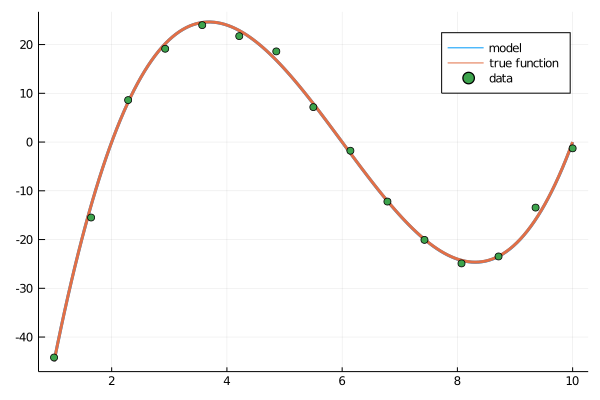

In [59]:
t = range(1, 10, length = 150)
plot(t, (t->f0(x0, t)).(t), lw = 3, label = "model")
plot!(t, true_f0.(t), lw = 3, label = "true function")
scatter!(t0, y0, label = "data")

Vraie fonction : $t \mapsto 0.1t + \dfrac{0.17}{t}$

Modèle à ajuster : $f:(t,x_1, x_2) \mapsto x_1t + \dfrac{x_2}{t} \\ s.c\  2x_1 + x_2 = 0.37$


In [86]:
true_f1(t::Float64) = 0.1*t^2 + 0.17/t
m = 20
t1 = range(0.1, 10, length = m)
y1 = true_f1.(t1) + randn(m)

# model, residual function and jacobian
f1(x::Vector, t::Float64) = x[1]*t^2 + x[2]/t
r1(x::Vector) = y1 - (t -> f1(x,t)).(t1)
jac_r1 = x::Vector -> ForwardDiff.jacobian(r1, x)


# constraints function ad jacobian
c1(x::Vector) = [2*x[1] + x[2] - 0.37]#, 3*x[1] - 5*x[2] + 0.1]
jac_c1 = x::Vector -> ForwardDiff.jacobian(c1, x)

x1 = nlcls_equality_constrained(r1, c1,[0., 0.] , jac_r1, jac_c1)



Critères de terminaison :
||c(x)|| = 0.37
||(Jx * Z)^T * fx|| = 1833.0130179425516 


 step 1 :
phase = GN
x = [0.0949867045194853, 0.18002659096102938]
dx = [0.0949867045194853, 0.18002659096102938]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 6.146194664324867e-13 

1 itérations


2-element Array{Float64,1}:
 0.0949867045194853
 0.18002659096102938

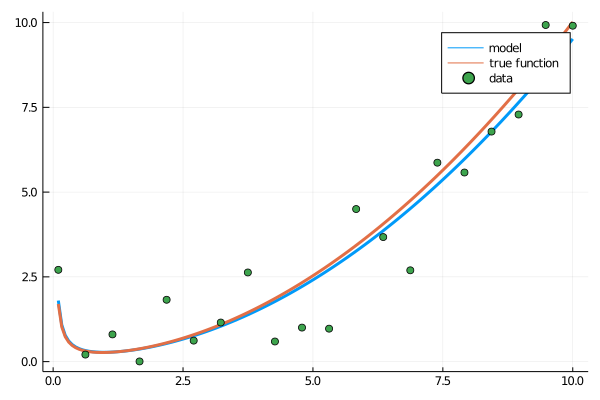

In [88]:
t = range(0.1, 10, length = 150)
plot(t, (t->f1(x1, t)).(t), lw = 3, label = "model")
plot!(t, true_f1.(t), lw=3,label = "true function")
scatter!(t1, y1, label = "data")

Vraie fonction : $t \mapsto 1 - \dfrac{t^2}{2} + \dfrac{t^4}{24}$

Modèle à ajuster : $f:(t, x_1, x_2) \mapsto 1 + x_1t^2 + {x_2}^3\dfrac{t^4}{3} \\
s.c\ x_1 + 2x_2 = \dfrac{1}{2}$

In [151]:
true_f2(t::Float64) = 1 - t^2/2 + t^4/24
m = 5
t2 = range(0, 4, length = m)
y2 = true_f2.(t2) + randn(m)

# model, residual function and jacobian
f2(x::Vector, t::Float64) = 1 + x[1]*t^2 + x[2]^3 * t^4 /3
r2(x::Vector) = y2 - (t -> f2(x,t)).(t2)
jac_r2 = x::Vector -> ForwardDiff.jacobian(r2, x)


# constraints function ad jacobian
c2(x::Vector) = [x[1] + 2*x[2] - 0.5]
jac_c2 = x::Vector -> ForwardDiff.jacobian(c2, x)

x2 = nlcls_equality_constrained(r2, c2,[0., 0.], jac_r2, jac_c2)

Critères de terminaison :
||c(x)|| = 0.5
||(Jx * Z)^T * fx|| = 16.40743409069072 


 step 1 :
phase = GN
x = [0.05181940390272868, 0.22409029804863564]
dx = [0.05181940390272868, 0.22409029804863564]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 15.963564937961362 


 step 2 :
phase = GN
x = [-0.06403396789937334, 0.28201698394968666]
dx = [-0.11585337180210202, 0.057926685901051045]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 5.880246127283201 


 step 3 :
phase = GN
x = [-0.14672846845238402, 0.32336423422619204]
dx = [-0.08269450055301067, 0.041347250276505355]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 5.467643969506733 


 step 4 :
phase = GN
x = [-0.2978366674621791, 0.39891833373108965]
dx = [-0.1511081990097951, 0.0755540995048976]
α = 1.0
Critères de terminaison :
||c(x)|| = 2.220446049250313e-16
||(Jx * Z)^T * fx|| = 12.475631914722253 


 step 5 :
phase = GN
x = [-0.49547371953082475, 0.497736859

dx = [0.14394927821071452, -0.034593362416413045]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0747625533778884
||(Jx * Z)^T * fx|| = 0.23222932276480746 


 step 52 :
phase = GN
x = [-0.5210703928592746, 0.5105351964296374]
dx = [-0.16425512372831802, 0.04474628517521484]
α = 1.0
Critères de terminaison :
||c(x)|| = 2.220446049250313e-16
||(Jx * Z)^T * fx|| = 5.5995271144584695 


 step 53 :
phase = GN
x = [-0.5007645473416711, 0.5003822736708355]
dx = [0.020305845517603498, -0.010152922758801862]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 0.09910530363685044 


 step 54 :
phase = Newton
x = [-0.35681526913095657, 0.4657889112544225]
dx = [0.14394927821071452, -0.034593362416413045]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0747625533778884
||(Jx * Z)^T * fx|| = 0.23222932276480746 


 step 55 :
phase = GN
x = [-0.5210703928592746, 0.5105351964296374]
dx = [-0.16425512372831802, 0.04474628517521484]
α = 1.0
Critères de terminaison :
||c(x)|| = 2.2204


 step 93 :
phase = Newton
x = [-0.35681526913095657, 0.4657889112544225]
dx = [0.14394927821071452, -0.034593362416413045]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0747625533778884
||(Jx * Z)^T * fx|| = 0.23222932276480746 


 step 94 :
phase = GN
x = [-0.5210703928592746, 0.5105351964296374]
dx = [-0.16425512372831802, 0.04474628517521484]
α = 1.0
Critères de terminaison :
||c(x)|| = 2.220446049250313e-16
||(Jx * Z)^T * fx|| = 5.5995271144584695 


 step 95 :
phase = GN
x = [-0.5007645473416711, 0.5003822736708355]
dx = [0.020305845517603498, -0.010152922758801862]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0
||(Jx * Z)^T * fx|| = 0.09910530363685044 


 step 96 :
phase = Newton
x = [-0.35681526913095657, 0.4657889112544225]
dx = [0.14394927821071452, -0.034593362416413045]
α = 1.0
Critères de terminaison :
||c(x)|| = 0.0747625533778884
||(Jx * Z)^T * fx|| = 0.23222932276480746 


 step 97 :
phase = GN
x = [-0.5210703928592746, 0.5105351964296374]
dx = [-0.16425512372831802

2-element Array{Float64,1}:
 -0.5210703928592746
  0.5105351964296374

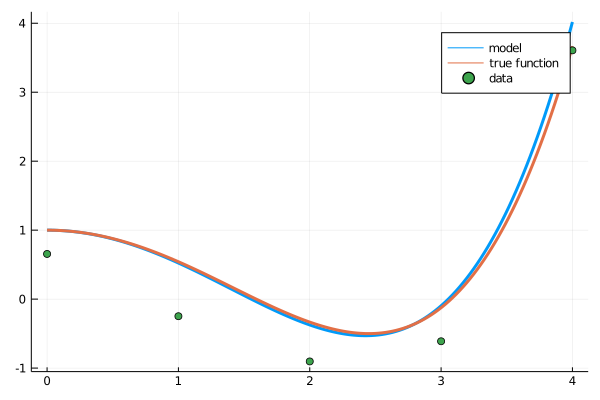

In [152]:
t = range(0, 4, length = 150)
plot(t, (t->f2(x2, t)).(t), lw = 3, label = "model")
plot!(t, true_f2.(t), lw=3,label = "true function")
scatter!(t2, y2, label = "data")